## Wikidata Knowledge Graph Extraction
Many recommendation algorithms (DKN, RippleNet, KGCN) use Knowledge Graphs as a source of information for the models. Here we found that one of the bottlenecks to benchmark current algorithms like DKN, RippleNet or KGCN is that they used Microsoft Satori. As Satori is not open source, it's a bit difficult to replicate the results found in the papers. The solution is using other open source KGs.

The goal of this notebook is to provide examples of how to interact with Wikipedia queries and Wikidata to extract a Knowledge Graph that can be used with the mentioned algorithms.

The steps to cover are:
- How to find a Wikidata entity (https://www.wikidata.org/wiki/Wikidata:Glossary/en from a text query
- How to find surrounding entities of an entity 
- Create a KG for Movielens

In [3]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")
print("System version: {}".format(sys.version))

import pandas as pd
from reco_utils.dataset.wikidata import (
    find_wikidataID,
    query_entity_links,
    read_linked_entities,
    query_entity_description
)

System version: 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:55:02) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]


## 1. Create a KG from linked entities in Wikidata from a list

In [8]:
name = ["The Godfather", "Al Pacino", "Tom Hanks", "Forrest Gump", "Julia Roberts", "", "My Best Friend's Wedding"]
result_linked = pd.DataFrame()

for n in name:
    entity_id = find_wikidataID(n)
    if entity_id != "entityNotFound":
        json_links = query_entity_links(entity_id)
        related_entities,related_names = read_linked_entities(json_links)
        d = pd.DataFrame({
            "name":n,
            "original_entity":[entity_id]* len(related_entities),
            "linked_entities":related_entities,
            "name_linked_entities":related_names})
        result_linked = pd.concat([result_linked, d])

In [9]:
result_linked[1:10]

,name,original_entity,linked_entities,name_linked_entities
1,The Godfather,Q47703,Q130232,drama film
2,The Godfather,Q47703,Q52162262,film based on literature
3,The Godfather,Q47703,Q7444356,gangster film
4,The Godfather,Q47703,Q959790,crime film
5,The Godfather,Q47703,Q243556,The Godfather
6,The Godfather,Q47703,Q102642,Diane Keaton
7,The Godfather,Q47703,Q108622,Talia Shire
8,The Godfather,Q47703,Q1147417,Simonetta Stefanelli
9,The Godfather,Q47703,Q1352034,Lenny Montana


### Visualize KG using networkx

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(result_linked, 'original_entity', 'linked_entities')

In [52]:
target_names = result_linked[["linked_entities", "name_linked_entities"]].drop_duplicates().rename(columns={"linked_entities": "labels", "name_linked_entities": "name"})
source_names = result_linked[["original_entity", "name"]].drop_duplicates().rename(columns={"original_entity": "labels"})
names = pd.concat([target_names, source_names])
names = names.set_index("labels")
names = names.to_dict()["name"]

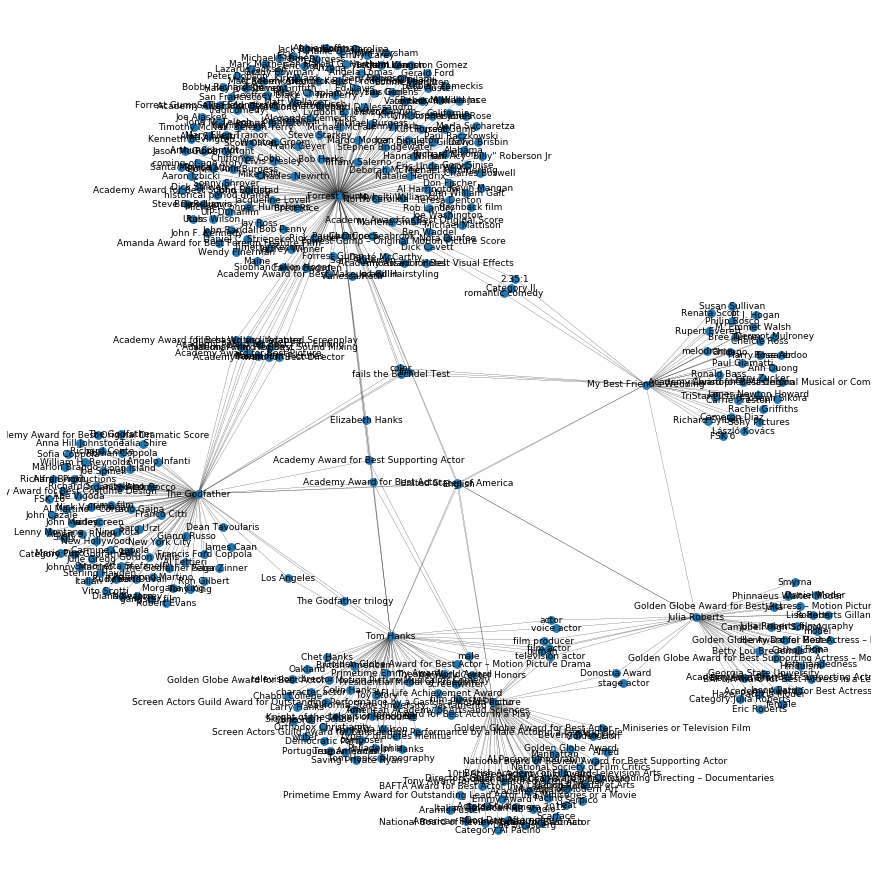

In [60]:
plt.figure(figsize=(12,12)) 
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=60,font_size=9, width = 0.2)
nx.draw_networkx_labels(G, pos, names, font_size=9)
plt.show()

## 2. Create an item description with short description and related entitites

In [9]:
# Create entity description with small description and string of linked entities
import pandas as pd
name = ["The Godfather", "Al Pacino", "Tom Hanks", "Forrest Gump", "Julia Roberts", "fake movie", "My Best Friend's Wedding"]
result_description = pd.DataFrame()

for n in name:
    entity_id = find_wikidataID(n)
    if entity_id != "entityNotFound":
        json_links = query_entity_links(entity_id)
        entity_description = query_entity_description(entity_id)
        related_entities,related_names = read_linked_entities(json_links)
        d = pd.DataFrame({"name": n,
                          "original_entity": entity_id,
                          "description":entity_description,
                          "related_names":', '.join(related_names)}, index = [0])
        result_description = pd.concat([result_description, d])

In [10]:
result_description.head(10)

,name,original_entity,description,related_names
0,The Godfather,Q47703,1972 US film directed by Francis Ford Coppola,"New Hollywood, drama film, film based on liter..."
0,Al Pacino,Q41163,American stage and film actor and director,"film actor, stage actor, film director, film p..."
0,Tom Hanks,Q2263,American actor and producer,"Democratic Party, television actor, film actor..."
0,Forrest Gump,Q134773,1994 American film directed by Robert Zemeckis,"drama film, comedy film, tragicomedy, flashbac..."
0,Julia Roberts,Q40523,American actress and producer,"television actor, film actor, stage actor, voi..."
0,My Best Friend's Wedding,Q918380,1997 film by P. J. Hogan,"melodrama, romantic comedy, Philip Bosco, Jose..."


## 3. Real Example with Movielens Dataset

In [21]:
# Obtain pairs of Movie Title - IDs from Movielens
from reco_utils.dataset import movielens
df = movielens.load_pandas_df('100k', ('UserId', 'ItemId', 'Rating', 'Timestamp'),
             title_col='Title',
             genres_col='Genres',
             year_col='Year'
        )
movies = df[["Title", "ItemId"]].drop_duplicates().reset_index()

4.93MB [00:07, 670kB/s]                             


In [22]:
movies["Title"][1:5]

1      L.A. Confidential (1997)
2           Heavyweights (1994)
3    Legends of the Fall (1994)
4           Jackie Brown (1997)
Name: Title, dtype: object

In [23]:
movies.shape

(1682, 3)

In [ ]:
%%time
# Get KG dataset for movies in Movielens
result_linked = pd.DataFrame()

for index, n in movies[1:100].iterrows():
    print("\r", "working on " + str(index) + " of" + str(movies.shape[0]), end='')
    entity_id = find_wikidataID(n["Title"] + " film")
    if entity_id != "entityNotFound":
        json_links = query_entity_links(entity_id)
        related_entities,related_names = read_linked_entities(json_links)
        d = pd.DataFrame({"original_entity":[entity_id]* len(related_entities),
                          "linked_entities":related_entities,
                          "name_linked_entities":related_names,
                          "movielens_title": n["Title"],
                          "movielens_id": n["ItemId"],
                         })
        result_linked = pd.concat([result_linked, d])

 working on 10 of1682

In [15]:
result_linked["movielens_title"].value_counts()

Aladdin (1992)                                                                 224
Silence of the Lambs, The (1991)                                               110
It's a Wonderful Life (1946)                                                    99
E.T. the Extra-Terrestrial (1982)                                               94
Sword in the Stone, The (1963)                                                  92
Ben-Hur (1959)                                                                  92
Wizard of Oz, The (1939)                                                        89
Batman (1989)                                                                   86
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)     85
Return of the Jedi (1983)                                                       83
Men in Black (1997)                                                             83
That Darn Cat! (1965)                                                           82
Righ

In [14]:
result_linked.to_csv("movielens_100k_wikidata.csv", index = False)